## TF-IDF representation and Logistic Regression

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, auc
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# read training df
X_train = pd.read_csv("X_train.csv")['clean_text']
y_train = pd.read_csv("y_train.csv")['profession']
s_train = pd.read_csv("s_train.csv")['gender']

# read val df
X_val = pd.read_csv("X_val.csv")['clean_text']
y_val = pd.read_csv("y_val.csv")['profession']
s_val = pd.read_csv("s_val.csv")['gender']

# read test df
X_test = pd.read_csv("X_test.csv")['clean_text']
y_test = pd.read_csv("y_test.csv")['profession']
s_test = pd.read_csv("s_test.csv")['gender']

In [ ]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1))
])

pipe.fit(X_train, y_train)

,steps,"[('vectorizer', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
y_pred_train = pipe.predict(X_train)
print("Accuracy on Training Data:", accuracy_score(y_train, y_pred_train))
print("Training Classification Report:\n", classification_report(y_train, y_pred_train))

Accuracy on Training Data: 0.8651069217564219
Training Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      3660
           1       0.84      0.72      0.77      6568
           2       0.89      0.93      0.91     21169
           3       0.91      0.64      0.75      1725
           4       0.93      0.77      0.85      1824
           5       0.87      0.89      0.88      3637
           6       0.94      0.95      0.95      9479
           7       0.89      0.81      0.85      2567
           8       0.95      0.72      0.82       964
           9       0.88      0.83      0.85      4545
          10       0.89      0.63      0.74       949
          11       0.75      0.87      0.80     12960
          12       0.89      0.83      0.86      4867
          13       0.91      0.85      0.88     12316
          14       0.87      0.86      0.87      5025
          15       0.97      0.54      0.70      1146
  

In [ ]:
## Baseline without finetuning on Validation Set
y_pred = pipe.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1:score:", f1_score(y_val, y_pred, average='macro'))

Accuracy: 0.8079309822915091
F1:score: 0.741482187743584


In [ ]:
## Baseline without finetuning on Test Set
y_pred = pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:score:", f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.8080933490799342
F1:score: 0.7447466110565492


In [ ]:
param_grid = {
    'vectorizer__ngram_range': [(1,1), (1,2)], # n-grams included from text
    'vectorizer__max_df': [1.0, 0.95, 0.90, 0.85], # words must appear in atleast x% of documents
    'lr__C': [0.1, 0.5, 1, 5, 10]  # strength of regularization
}

best_model = None
best_params = None
best_accuracy = 0
best_f1 = 0
param_num = 0

for max_df_ in param_grid['vectorizer__max_df']:
    for n_gram in param_grid['vectorizer__ngram_range']:

        vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', max_df = max_df_, ngram_range = n_gram)
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_val_tfidf = vectorizer.transform(X_val)

        for C in param_grid['lr__C']:
            lr = LogisticRegression(solver='saga', n_jobs=-1, C = C, penalty = 'l2')
            lr.fit(X_train_tfidf, y_train)
            y_val_pred = lr.predict(X_val_tfidf)

            accuracy = accuracy_score(y_val_pred, y_val)
            f1 = f1_score(y_val_pred, y_val, average = 'macro')
            param_num += 1

            print(f"Params {param_num}: (max_df = {max_df_}, n_gram = {n_gram}, C = {C}), Accuracy: {accuracy}, F1: {f1}")

            if accuracy > best_accuracy and f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model = lr
                best_params = (max_df_, n_gram, C)

Params 1: (max_df = 1.0, n_gram = (1, 1), C = 0.1), Accuracy: 0.7593713737954695, F1: 0.6062555523246601
Params 2: (max_df = 1.0, n_gram = (1, 1), C = 0.5), Accuracy: 0.8016245396296857, F1: 0.7237096512345446
Params 3: (max_df = 1.0, n_gram = (1, 1), C = 1), Accuracy: 0.8079309822915091, F1: 0.741482187743584
Params 4: (max_df = 1.0, n_gram = (1, 1), C = 5), Accuracy: 0.8079309822915091, F1: 0.7485967448973351
Params 5: (max_df = 1.0, n_gram = (1, 1), C = 10), Accuracy: 0.8039453105292367, F1: 0.7453612087749448
Params 6: (max_df = 1.0, n_gram = (1, 2), C = 0.1), Accuracy: 0.7230462640633671, F1: 0.5041706452171364
Params 7: (max_df = 1.0, n_gram = (1, 2), C = 0.5), Accuracy: 0.7937288734170829, F1: 0.6933640065550388
Params 8: (max_df = 1.0, n_gram = (1, 2), C = 1), Accuracy: 0.8068462741536754, F1: 0.7276900353464283
Params 9: (max_df = 1.0, n_gram = (1, 2), C = 5), Accuracy: 0.8192573533121437, F1: 0.7583327458632391
Params 10: (max_df = 1.0, n_gram = (1, 2), C = 10), Accuracy: 0.8

In [ ]:
best_params = (1.0, (1,2), 10)

In [ ]:
max_df_, n_gram, C = best_params
print(f"Best Metrics Found Using Validation Set")
print(f"n_gram: {n_gram}")
print(f"max_df: {max_df_}")
print(f"C Regularization: {C}")
print(f"Accuracy{best_accuracy} and F1: {best_f1}")

Best Metrics Found Using Validation Set
n_gram: (1, 2)
max_df: 0.85
C Regularization: 10
Accuracy0.8205943191564502 and F1: 0.7628417308951302


In [ ]:
pipe_ft = Pipeline([
    ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', max_df = max_df_, ngram_range = n_gram)),
    ('lr', LogisticRegression(solver='saga', n_jobs=-1, C = C, penalty = 'l2'))
])

pipe_ft.fit(X_train, y_train)

,steps,"[('vectorizer', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
y_pred = pipe_ft.predict(X_test)
print("Final Test Accuracy Post Finetuning")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:score:", f1_score(y_test, y_pred, average='macro'))

Final Test Accuracy Post Finetuning
Accuracy: 0.8220028465009236
F1:score: 0.7645533368418019


In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      1193
           1       0.64      0.74      0.69      2189
           2       0.90      0.86      0.88      8491
           3       0.67      0.84      0.74       528
           4       0.72      0.87      0.79       579
           5       0.84      0.78      0.81      1501
           6       0.94      0.94      0.94      3625
           7       0.79      0.84      0.82       932
           8       0.66      0.90      0.76       274
           9       0.79      0.80      0.79      1730
          10       0.59      0.80      0.68       268
          11       0.77      0.68      0.72      5667
          12       0.76      0.81      0.78      1758
          13       0.82      0.87      0.84      4473
          14       0.81      0.80      0.80      1940
          15       0.52      0.95      0.67       244
          16       0.56      0.63      0.59       566
          17       0.66    

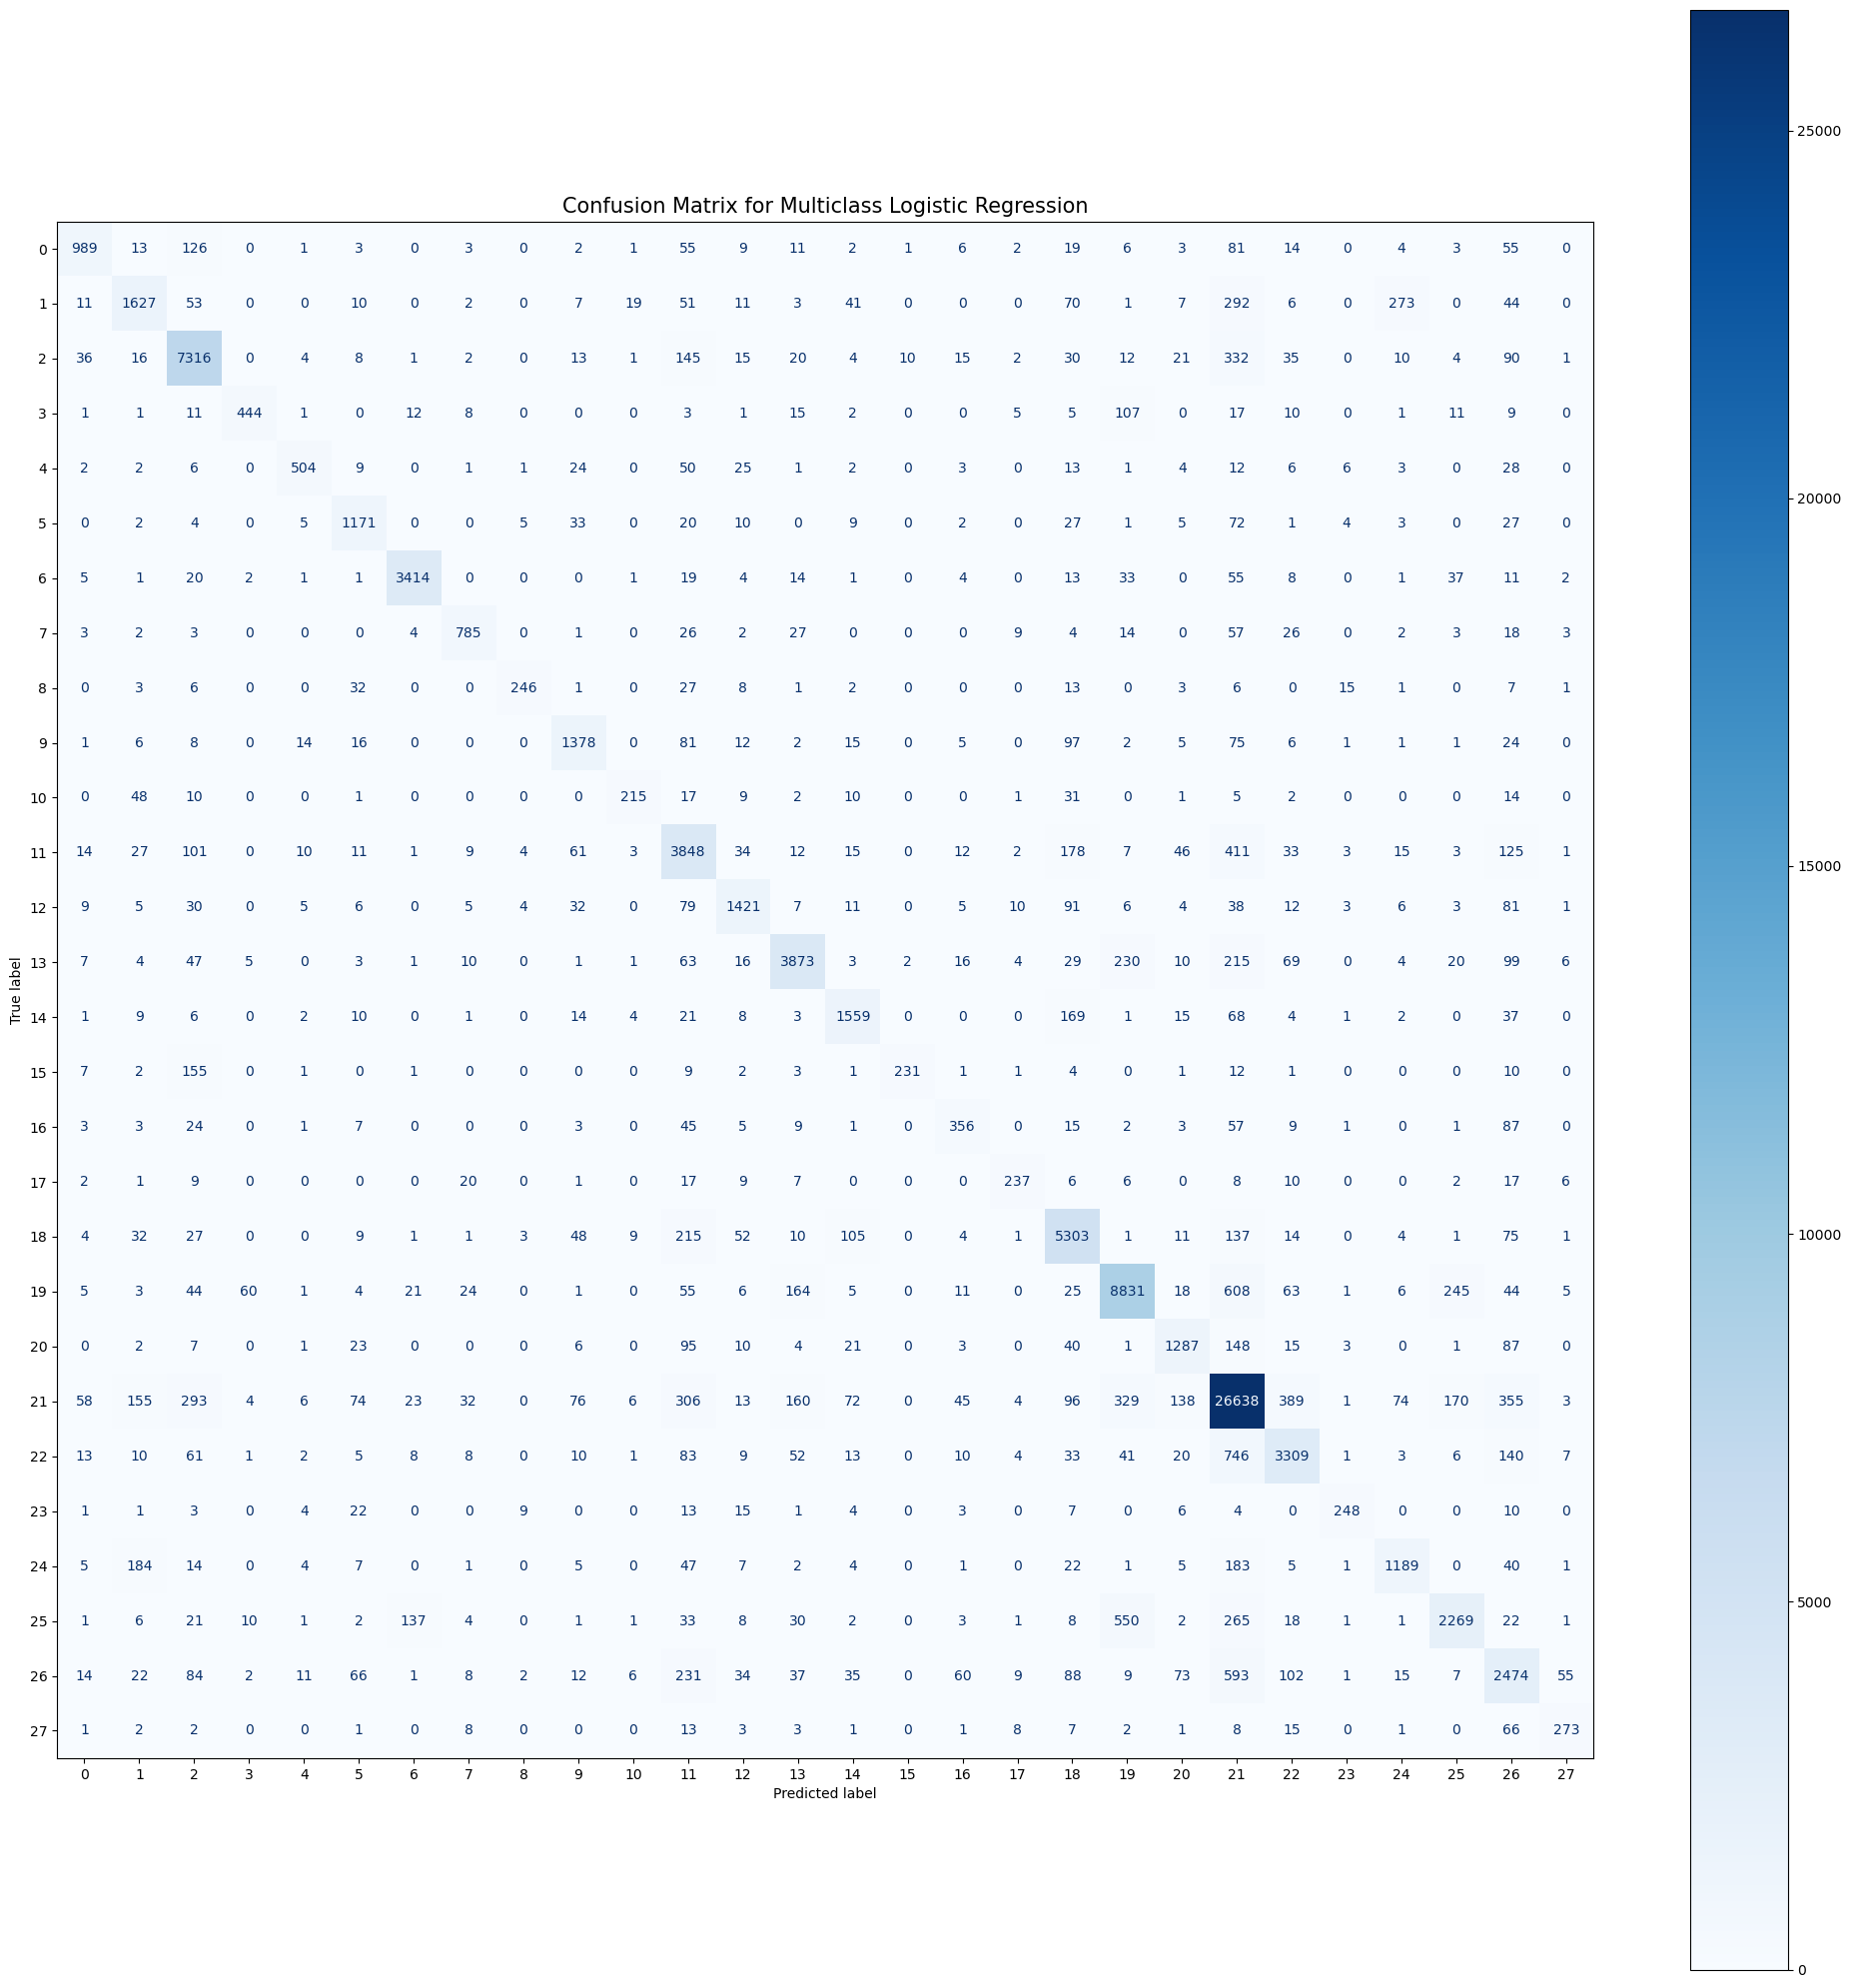

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
ConfusionMatrixDisplay.from_estimator(pipe_ft, X_test, y_test, cmap='Blues', ax= ax)
plt.title("Confusion Matrix for Multiclass Logistic Regression", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
male_mask = s_test == 0
female_mask = s_test == 1

male_test_y = y_test[male_mask]
female_test_y = y_test[female_mask]

male_ypred = y_pred[male_mask]
female_ypred = y_pred[female_mask]

print("\nMale Classification Report of Tuned Baseline Logistic Regression Classifier")
print(classification_report(male_ypred, male_test_y))
print("_"*110)
print("\nFemale Classification Report of Tuned Baseline Logistic Regression Classifier")
print(classification_report(female_ypred, female_test_y))


Male Classification Report of Tuned Baseline Logistic Regression Classifier
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       737
           1       0.64      0.76      0.69      1624
           2       0.90      0.87      0.89      5195
           3       0.69      0.85      0.76       395
           4       0.73      0.88      0.79       460
           5       0.83      0.80      0.82      1213
           6       0.93      0.94      0.94      2337
           7       0.59      0.46      0.52        91
           8       0.68      0.91      0.78       238
           9       0.79      0.81      0.80      1152
          10       0.55      0.61      0.58        64
          11       0.76      0.65      0.70      2962
          12       0.41      0.42      0.41       317
          13       0.77      0.71      0.74       471
          14       0.81      0.80      0.81      1069
          15       0.36      0.86      0.51        28
    

In [ ]:
def class_accuracy(y_pred, y_true):
    accuracy = []
    for c in range(28):
        mask = y_true == c
        accuracy.append(accuracy_score(y_true[mask], y_pred[mask]))
    return accuracy

total_accuracy = class_accuracy(y_pred, y_test)
male_accuracy = class_accuracy(male_ypred, male_test_y)
female_accuracy = class_accuracy(female_ypred, female_test_y)
diff_accuracy = np.array(male_accuracy) - np.array(female_accuracy)
absdiff_accuracy = np.abs(diff_accuracy)

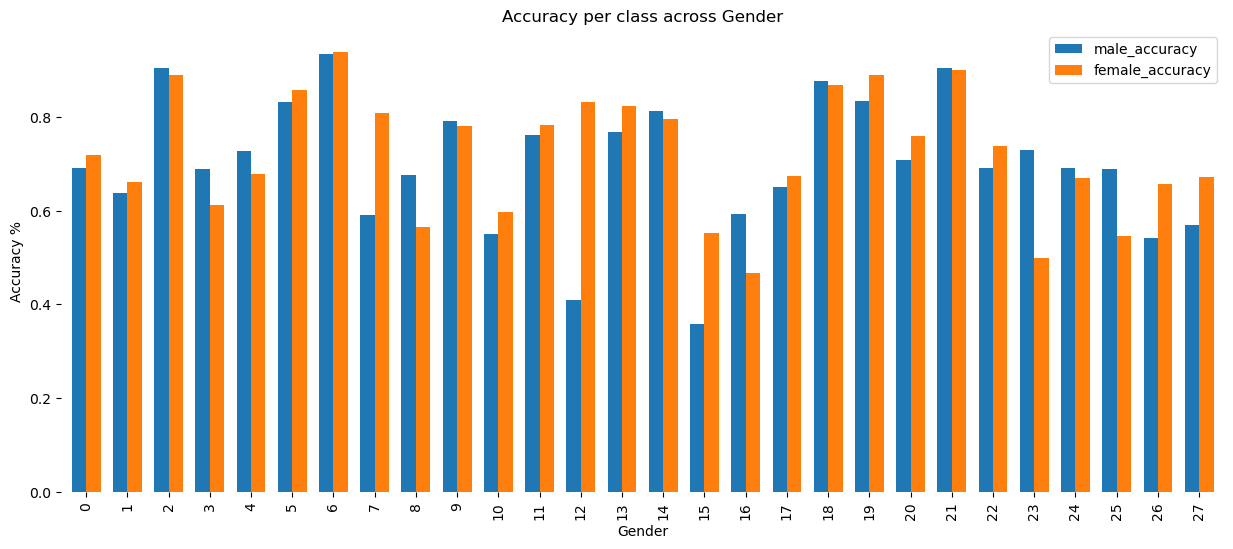

In [ ]:
group = list(range(28))
accuracy_df = pd.DataFrame({
    "group" : group,
    "male_accuracy": male_accuracy,
    "female_accuracy": female_accuracy
})

accuracy_df.set_index('group').plot(kind='bar',
                                    width=0.7,
                                    figsize=(15, 6),
                                    title ="Accuracy per class across Gender",
                                    ylabel = "Accuracy %",
                                    xlabel = "Gender"
                                   )
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)